# Replicate GluNet on OhioT1DM

GluNet was mainly reported as a personalized model

In [1]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

## 1. Load in the Glucose, Meal, and Insulin data

For cgm data, do general seperation based on time interval = 1hour:

smaller than 1 hour, do spline interpolation (later)

larger than 1 hour, seperate it as another dataset for training

In [2]:
filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/559-ws-training.xml"
tree = ET.parse(filepath)
root = tree.getroot()

for child in root:
    print(child.tag)

glucose_level
finger_stick
basal
temp_basal
bolus
meal
sleep
work
stressors
hypo_event
illness
exercise
basis_heart_rate
basis_gsr
basis_skin_temperature
basis_air_temperature
basis_steps
basis_sleep


In [3]:
def round_up_to_nearest_five_minutes(ts):
    # Parse the timestamp
    dt = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
    
    # Calculate minutes to add to round up to the nearest 5 minutes
    minutes_to_add = (5 - dt.minute % 5) % 5
    if minutes_to_add == 0 and dt.second == 0:
        # If exactly on a 5 minute mark and second is 0, no need to add time
        minutes_to_add = 5
    
    # Add the necessary minutes
    new_dt = dt + timedelta(minutes=minutes_to_add)
    
    # Return the new timestamp in the same format
    return new_dt.strftime( "%d-%m-%Y %H:%M:%S")

In [4]:
# Need to set the 
def read_ohio(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts'])
            entry0['ts'] = adjusted_ts
        ts = entry0['ts']
        entry0['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            # t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            # t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            # delt = t1 - t0
            # if category == "glucose_level":
            #     if delt <= interval_timedelta:
            #         res[-1].append([entry])
            #     else:
            #         res.append([entry])
            # else:
            ts = entry['ts']
            if round == True:
                adjusted_ts = round_up_to_nearest_five_minutes(ts)
                entry['ts'] = adjusted_ts
            entry['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
            res.append([entry])
    return res


In [6]:
filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/570-ws-training.xml"
glucose = read_ohio(filepath, "glucose_level", False)

In [7]:
glucose[:5]

[[{'ts': datetime.datetime(2021, 12, 7, 16, 29), 'value': '101'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 34), 'value': '100'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 39), 'value': '100'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 44), 'value': '99'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 49), 'value': '98'}]]

# Threshold filter

The paper didn't report how did they do the threshold filtering, and didn't provide the filter value. So in this case, to avoid bias, we should? not conduct any threshold filtering

In [8]:
glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

# Create the multi-channel database
g_data = []
for timestamp in glucose_dict:
    record = {
        'timestamp': timestamp,
        'glucose_value': glucose_dict[timestamp],
        # 'meal_type': None,
        # 'meal_carbs': 0
    }
    
    g_data.append(record)

In [9]:
# Create DataFrame
glucose_df = pd.DataFrame(g_data)

# Convert glucose values to numeric type for analysis
glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])

# Calculate percentiles
lower_percentile = np.percentile(glucose_df['glucose_value'], 2)
upper_percentile = np.percentile(glucose_df['glucose_value'], 98)

# Print thresholds
print(f"2% lower threshold: {lower_percentile}")
print(f"98% upper threshold: {upper_percentile}")

2% lower threshold: 71.0
98% upper threshold: 308.0


In [10]:
glucose_df

,timestamp,glucose_value
0,2021-12-07 16:29:00,101
1,2021-12-07 16:34:00,100
2,2021-12-07 16:39:00,100
3,2021-12-07 16:44:00,99
4,2021-12-07 16:49:00,98
...,...,...
10977,2022-01-16 23:39:00,113
10978,2022-01-16 23:44:00,118
10979,2022-01-16 23:49:00,120
10980,2022-01-16 23:54:00,123


# Spline interpolation and extrapolation
: Spline interpolation or extrapolation technique are used when the missing CGM data are less than one
hour (12 samples). Spline interpolation is implemented because
it is more accurate, and simpler than some other methods [24].
If the missing CMG data are longer than 1 hour, we consider it
as a separate dataset in training. In the inference, extrapolation
is adopted because future samples cannot be used in forecasting.

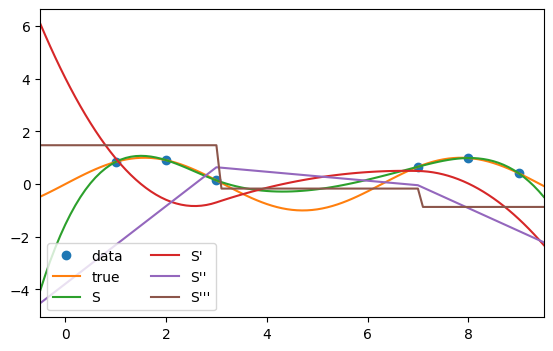

In [31]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
x = np.array([1,2,3,7,8,9])
y = np.sin(x)
cs = CubicSpline(x, y)
xs = np.arange(-0.5, 9.6, 0.1)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, np.sin(xs), label='true')
ax.plot(xs, cs(xs), label="S")
ax.plot(xs, cs(xs, 1), label="S'")
ax.plot(xs, cs(xs, 2), label="S''")
ax.plot(xs, cs(xs, 3), label="S'''")
ax.set_xlim(-0.5, 9.5)
ax.legend(loc='lower left', ncol=2)
plt.show()

In [11]:
# Example DataFrame setup
# data = {
#     'timestamp': pd.to_datetime([
#         '2021-12-07 01:17:00', '2021-12-07 01:22:00', '2021-12-07 01:27:00', '2021-12-07 01:32:00', '2021-12-07 01:37:00',
#         '2021-12-07 04:00:00',  # Large gap example
#         '2021-12-07 06:00:00',  # Another large gap example
#         '2022-01-17 23:36:00', '2022-01-17 23:41:00', '2022-01-17 23:46:00', '2022-01-17 23:51:00', '2022-01-17 23:56:00'
#     ]),
#     'glucose_value': [101, 98, 104, 112, 120, 130, 135, 161, 164, 168, 172, 176]
# }
# glucose_df

def segement_data_as_1hour(data):
    df = pd.DataFrame(data)

    # Calculate time differences
    df['time_diff'] = df['timestamp'].diff()

    # Identify large gaps
    df['new_segment'] = df['time_diff'] > pd.Timedelta(hours=1)

    # Find indices where new segments start
    segment_starts = df[df['new_segment']].index

    # Initialize an empty dictionary to store segments
    segments = {}
    prev_index = 0

    # Loop through each segment start and slice the DataFrame accordingly
    for i, start in enumerate(segment_starts, 1):
        segments[f'segment_{i}'] = df.iloc[prev_index:start].reset_index(drop=True)
        prev_index = start

    # Add the last segment from the last gap to the end of the DataFrame
    segments[f'segment_{len(segment_starts) + 1}'] = df.iloc[prev_index:].reset_index(drop=True)

    # Optionally remove helper columns from each segment
    for segment in segments.values():
        segment.drop(columns=['time_diff', 'new_segment'], inplace=True)
    
    return segments

# Example: print each segment
segments = segement_data_as_1hour(glucose_df)




In [11]:
# sequence = "segment_3"

# for ts in range(len(segments[sequence]['timestamp'])-1):
#     if segments[sequence]['timestamp'][ts+1] - segments[sequence]['timestamp'][ts] > timedelta(minutes = 5):
#         print("before: ", segments[sequence]['timestamp'][ts])
#         print("after: ", segments[sequence]['timestamp'][ts+1])

before:  2021-12-12 04:54:00
after:  2021-12-12 05:29:00
before:  2021-12-12 12:34:00
after:  2021-12-12 12:44:00
before:  2021-12-12 22:09:00
after:  2021-12-12 22:39:00


In [69]:
# segments['segment_3']

,timestamp,glucose_value
0,2021-12-11 09:14:00,170
1,2021-12-11 09:19:00,165
2,2021-12-11 09:24:00,160
3,2021-12-11 09:29:00,155
4,2021-12-11 09:34:00,150
...,...,...
618,2021-12-13 13:44:00,169
619,2021-12-13 13:49:00,175
620,2021-12-13 13:54:00,172
621,2021-12-13 13:59:00,169


In [13]:
# datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())


C:\Users\username\AppData\Local\Temp\ipykernel_20636\263403781.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())


In [14]:
# reference_time = min(segments[sequence]['timestamp'])

# # Convert datetime objects to the number of seconds since the reference time
# datetime_seconds_since_start = [((dt - reference_time).total_seconds())/60 for dt in datetime_list] # Make it into minute
# original_timestamp_in_segement = [((dt - reference_time).total_seconds())/60 for dt in segments[sequence]['timestamp']]

In [16]:
# import numpy as np
# from scipy.interpolate import CubicSpline
# import matplotlib.pyplot as plt

# x = original_timestamp_in_segement
# y = np.array(segments['segment_3']['glucose_value'])
# cs = CubicSpline(x, y)
# xs = datetime_seconds_since_start

# interpolated_xs = cs(xs)

In [20]:
# # Generate datetime index for each entry in the numpy array
# time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')

# # Create DataFrame from the time index and glucose values
# df_interpolated = pd.DataFrame({'timestamp': time_index_interpolated, 'glucose_value': interpolated_xs})

# # Print the DataFrame to verify
# print(df_interpolated)

              timestamp  glucose_value
0   2021-12-11 09:14:00          170.0
1   2021-12-11 09:19:00          165.0
2   2021-12-11 09:24:00          160.0
3   2021-12-11 09:29:00          155.0
4   2021-12-11 09:34:00          150.0
..                  ...            ...
630 2021-12-13 13:44:00          169.0
631 2021-12-13 13:49:00          175.0
632 2021-12-13 13:54:00          172.0
633 2021-12-13 13:59:00          169.0
634 2021-12-13 14:04:00          178.0

[635 rows x 2 columns]


C:\Users\username\AppData\Local\Temp\ipykernel_20636\971159923.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')


In [12]:
def detect_missing_and_spline_interpolate(segments):
    for sequence in segments:
        # sequence = "segment_3"
        detected_missing = 0
        for ts in range(len( segments[sequence]['timestamp'])-1):
            if segments[sequence]['timestamp'][ts+1] - segments[sequence]['timestamp'][ts] > timedelta(minutes = 6):
                print(sequence)
                print("before: ", segments[sequence]['timestamp'][ts])
                print("after: ", segments[sequence]['timestamp'][ts+1])
                detected_missing = 1
            
        if detected_missing == 1:
            datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
            reference_time = min(segments[sequence]['timestamp'])

            # Convert datetime objects to the number of seconds since the reference time
            datetime_seconds_since_start = [((dt - reference_time).total_seconds())/60 for dt in datetime_list] # Make it into minute
            original_timestamp_in_segement = [((dt - reference_time).total_seconds())/60 for dt in segments[sequence]['timestamp']]

            x = original_timestamp_in_segement
            y = np.array(segments[sequence]['glucose_value'])
            cs = CubicSpline(x, y)
            xs = datetime_seconds_since_start

            interpolated_xs = cs(xs)
            time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')

            # Create DataFrame from the time index and glucose values
            df_interpolated = pd.DataFrame({'timestamp': time_index_interpolated, 'glucose_value': interpolated_xs})
            segments[sequence] = df_interpolated

    return segments

                

In [13]:
interpolated_segements = detect_missing_and_spline_interpolate(segments)

segment_1
before:  2021-12-07 22:14:00
after:  2021-12-07 22:34:00
segment_6
before:  2021-12-22 17:03:00
after:  2021-12-22 18:03:00
segment_6
before:  2021-12-22 20:18:00
after:  2021-12-22 20:28:00
segment_8
before:  2021-12-27 07:53:00
after:  2021-12-27 08:28:00
segment_9
before:  2022-01-02 07:32:00
after:  2022-01-02 08:27:00


C:\Users\username\AppData\Local\Temp\ipykernel_9336\2206620972.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
C:\Users\username\AppData\Local\Temp\ipykernel_9336\2206620972.py:26: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')


In [14]:
interpolated_segements['segment_2']["timestamp"][0]

Timestamp('2021-12-13 17:08:00')

# Align other factors with the glucose information

## Include meal info

In [15]:
meal = read_ohio(filepath, "meal", False)

flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)

meal_df['assigned'] = False

meal_df[:10]

,ts,type,carbs,assigned
0,2021-12-07 18:28:00,Dinner,65,False
1,2021-12-07 21:33:00,Snack,5,False
2,2021-12-08 06:14:00,Breakfast,97,False
3,2021-12-08 12:04:00,Lunch,120,False
4,2021-12-08 16:50:00,Snack,38,False
5,2021-12-08 19:24:00,Dinner,150,False
6,2021-12-08 21:36:00,Snack,60,False
7,2021-12-09 06:26:00,Breakfast,80,False
8,2021-12-09 12:01:00,Lunch,75,False
9,2021-12-09 19:39:00,Dinner,135,False


In [16]:
# Function to align and update segments with meal data
def update_segments_with_meals(segments, meal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['carbs'] = 0

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest meal timestamp and its carb information
            meal_df['time_difference'] = abs(meal_df['ts'] - row['timestamp'])
            closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]
            
            # Check if the closest meal is within 5 minutes
            if closest_meal['time_difference'] <= pd.Timedelta(minutes=5):
                # Ensure that the meal is assigned to only one segment and is the closest
                if not meal_df.at[closest_meal.name, 'assigned']:
                    segment_df.at[i, 'carbs'] = closest_meal['carbs']
                    meal_df.at[closest_meal.name, 'assigned'] = True  # Mark as assigned
                else:
                    # Check if the current timestamp is closer than the one it was assigned to
                    assigned_index = segment_df[segment_df['carbs'] == closest_meal['carbs']].index[0]
                    if row['timestamp'] - closest_meal['ts'] < segment_df.at[assigned_index, 'timestamp'] - closest_meal['ts']:
                        # Reassign the meal to the new closer timestamp
                        segment_df.at[assigned_index, 'carbs'] = 0  # Remove carbs from previously assigned timestamp
                        segment_df.at[i, 'carbs'] = closest_meal['carbs']  # Assign carbs to the new closer timestamp
            # else:
            #     print(f"Meal type {meal['type']} on {meal['ts']} is too far from closest timestamp in {closest_segment} with a difference of {closest_diff}.")

    return segments

        # # Iterate through each timestamp in the segment
        # for i, row in segment_df.iterrows():
        #     # Find the closest meal timestamp and its carb information
        #     unassigned_meals = meal_df[meal_df['assigned'] == False]
        #     if not unassigned_meals.empty:
        #         unassigned_meals['time_difference'] = abs(unassigned_meals['ts'] - row['timestamp'])
        #         closest_meal = unassigned_meals.loc[unassigned_meals['time_difference'].idxmin()]

        #         if closest_meal['time_difference'] <= pd.Timedelta(minutes=5):
        #             segment_df.at[i, 'carbs'] = closest_meal['carbs']
        #             meal_df.at[closest_meal.name, 'assigned'] = True  # Mark as assigned


    return segments

# Update the segments with meal data
meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)


C:\Users\username\AppData\Local\Temp\ipykernel_9336\1468253959.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
C:\Users\username\AppData\Local\Temp\ipykernel_9336\1468253959.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
C:\Users\username\AppData\Local\Temp\ipykernel_9336\1468253959.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '85' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs

## Include the basal information

In [17]:
basal = read_ohio(filepath, "basal", False)

flattened_basal_data = [item[0] for item in basal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
basal_df = pd.DataFrame(flattened_basal_data)

basal_df['assigned'] = False
basal_df['end_ts'] = basal_df['ts'].shift(-1)
basal_df[:10]

,ts,value,assigned,end_ts
0,2021-12-07 00:00:00,0.93,False,2021-12-07 04:00:00
1,2021-12-07 04:00:00,1.1,False,2021-12-07 05:00:00
2,2021-12-07 05:00:00,1.25,False,2021-12-07 07:00:00
3,2021-12-07 07:00:00,1.3,False,2021-12-07 11:00:00
4,2021-12-07 11:00:00,0.7,False,2021-12-07 17:00:00
5,2021-12-07 17:00:00,0.9,False,2021-12-08 00:00:00
6,2021-12-08 00:00:00,0.93,False,2021-12-08 04:00:00
7,2021-12-08 04:00:00,1.1,False,2021-12-08 05:00:00
8,2021-12-08 05:00:00,1.25,False,2021-12-08 07:00:00
9,2021-12-08 07:00:00,1.3,False,2021-12-08 11:00:00


In [18]:
# Function to align and update segments with meal data
def update_segments_with_basal(segments, basal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['basal_rate'] = None

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest meal timestamp and its carb information
            for _, basal_row in basal_df.iterrows():
                if basal_row['ts'] <= row['timestamp'] < (basal_row['end_ts'] if pd.notna(basal_row['end_ts']) else pd.Timestamp('2099-12-31')):
                    segment_df.at[i, 'basal_rate'] = basal_row['value']
                    break

    return segments

# Update the segments with meal data
basal_updated_segments = update_segments_with_basal(meal_updated_segments, basal_df)


In [19]:
basal_updated_segments['segment_1'][:50]

,timestamp,glucose_value,carbs,basal_rate
0,2021-12-07 16:29:00,101.0,0,0.7
1,2021-12-07 16:34:00,100.0,0,0.7
2,2021-12-07 16:39:00,100.0,0,0.7
3,2021-12-07 16:44:00,99.0,0,0.7
4,2021-12-07 16:49:00,98.0,0,0.7
5,2021-12-07 16:54:00,98.0,0,0.7
6,2021-12-07 16:59:00,95.0,0,0.7
7,2021-12-07 17:04:00,94.0,0,0.9
8,2021-12-07 17:09:00,92.0,0,0.9
9,2021-12-07 17:14:00,90.0,0,0.9


## Include bolus

In [22]:
# Read in bolus and temp basal information
# Need to set the 
def read_ohio_bolus_tempbasal(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_begin'])
            entry0['ts_begin'] = adjusted_ts
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_end'])
            entry0['ts_end'] = adjusted_ts
        
        entry0['ts_begin'] = datetime.strptime(entry0['ts_begin'], "%d-%m-%Y %H:%M:%S")
        entry0['ts_end'] = datetime.strptime(entry0['ts_end'], "%d-%m-%Y %H:%M:%S")

        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            # t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            # t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            # delt = t1 - t0
            # if category == "glucose_level":
            #     if delt <= interval_timedelta:
            #         res[-1].append([entry])
            #     else:
            #         res.append([entry])
            # else:
            ts_begin = entry['ts_begin']
            ts_end = entry['ts_end']
            if round == True:
                adjusted_ts_begin = round_up_to_nearest_five_minutes(ts_begin)
                entry['ts_end'] = adjusted_ts_begin
                adjusted_ts_end = round_up_to_nearest_five_minutes(ts_end)
                entry['ts_end'] = adjusted_ts_end
            entry['ts_begin'] = datetime.strptime(entry['ts_begin'], "%d-%m-%Y %H:%M:%S")
            entry['ts_end'] = datetime.strptime(entry['ts_end'], "%d-%m-%Y %H:%M:%S")
            if category == "bolus":
                if entry['ts_begin'] != entry['ts_end']:
                    print("Unequal: begin: " + str(entry['ts_begin']) + "end: " + str(entry['ts_end']))
            res.append([entry])
    return res

In [23]:
# Merge Bolus into the dataframe
bolus = read_ohio_bolus_tempbasal(filepath, "bolus", False)


Unequal: begin: 2021-12-07 07:41:58end: 2021-12-07 08:11:58
Unequal: begin: 2021-12-07 18:34:32end: 2021-12-07 19:04:32
Unequal: begin: 2021-12-08 06:18:52end: 2021-12-08 06:48:52
Unequal: begin: 2021-12-08 12:09:16end: 2021-12-08 12:39:16
Unequal: begin: 2021-12-08 16:50:52end: 2021-12-08 17:20:52
Unequal: begin: 2021-12-08 19:26:31end: 2021-12-08 19:56:31
Unequal: begin: 2021-12-08 21:36:59end: 2021-12-08 22:06:59
Unequal: begin: 2021-12-09 06:29:18end: 2021-12-09 06:59:18
Unequal: begin: 2021-12-09 12:04:48end: 2021-12-09 12:34:48
Unequal: begin: 2021-12-09 19:42:56end: 2021-12-09 20:12:56
Unequal: begin: 2021-12-10 06:11:17end: 2021-12-10 06:41:17
Unequal: begin: 2021-12-10 13:31:26end: 2021-12-10 14:01:26
Unequal: begin: 2021-12-10 19:59:05end: 2021-12-10 20:29:05
Unequal: begin: 2021-12-11 09:26:02end: 2021-12-11 09:56:02
Unequal: begin: 2021-12-11 16:57:23end: 2021-12-11 17:27:23
Unequal: begin: 2021-12-11 20:20:42end: 2021-12-11 20:50:42
Unequal: begin: 2021-12-12 10:07:10end: 

In [24]:
flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist

# Convert to DataFrame
bolus_df = pd.DataFrame(flattened_bolus_data)

bolus_df['assigned'] = False
bolus_df[:10]

,ts_begin,ts_end,type,dose,bwz_carb_input,assigned
0,2021-12-07 07:36:54,2021-12-07 07:36:54,normal dual,8.0,102,False
1,2021-12-07 07:41:58,2021-12-07 08:11:58,square dual,6.4,0,False
2,2021-12-07 18:31:52,2021-12-07 18:31:52,normal dual,4.0,65,False
3,2021-12-07 18:34:32,2021-12-07 19:04:32,square dual,4.1,0,False
4,2021-12-07 22:19:46,2021-12-07 22:19:46,normal,0.7,0,False
5,2021-12-08 06:14:22,2021-12-08 06:14:22,normal dual,6.7,97,False
6,2021-12-08 06:18:52,2021-12-08 06:48:52,square dual,6.1,0,False
7,2021-12-08 12:04:11,2021-12-08 12:04:11,normal dual,9.6,120,False
8,2021-12-08 12:09:16,2021-12-08 12:39:16,square dual,7.5,0,False
9,2021-12-08 15:46:52,2021-12-08 15:46:52,normal,2.9,0,False


In [25]:

def update_segments_with_bolus(segments, bolus_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'dose' column to zeros
        segment_df['bolus_dose'] = 0

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest bolus timestamp and its carb information
            bolus_df['time_difference'] = abs(bolus_df['ts_begin'] - row['timestamp'])
            closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
            
            # Check if the closest bolus is within 5 minutes
            if closest_bolus['time_difference'] <= pd.Timedelta(minutes=5):
                # Ensure that the bolus is assigned to only one segment and is the closest
                if not bolus_df.at[closest_bolus.name, 'assigned']:
                    segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
                    bolus_df.at[closest_bolus.name, 'assigned'] = True  # Mark as assigned
                else:
                    # Check if the current timestamp is closer than the one it was assigned to
                    assigned_index = segment_df[segment_df['bolus_dose'] == closest_bolus['dose']].index[0]
                    if row['timestamp'] - closest_bolus['ts_begin'] < closest_bolus['ts_begin'] - segment_df.at[assigned_index, 'timestamp']:
                        # Reassign the bolus to the new closer timestamp
                        segment_df.at[assigned_index, 'bolus_dose'] = 0  # Remove dose from previously assigned timestamp
                        segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']  # Assign dose to the new closer timestamp
            # else:
            #     print(f"bolus type {bolus['type']} on {bolus['ts']} is too far from closest timestamp in {closest_segment} with a difference of {closest_diff}.")

    return segments
# def update_segments_with_bolus(segments, bolus_df):
#     for segment_name, segment_df in segments.items():
#         # Initialize the 'bolus' column to zeros
#         segment_df['bolus_dose'] = 0

#         # Iterate through each timestamp in the segment
#         for i, row in segment_df.iterrows():
#             # Find the closest meal timestamp and its carb information
#             unassigned_bolus = bolus_df[bolus_df['assigned'] == False]
#             if not unassigned_bolus.empty:
#                 unassigned_bolus['time_difference'] = abs(unassigned_bolus['ts_begin'] - row['timestamp'])
#                 closest_bolus = unassigned_bolus.loc[unassigned_bolus['time_difference'].idxmin()]

#                 if closest_bolus['time_difference'] <= pd.Timedelta(minutes=5):
#                     segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
#                     bolus_df.at[closest_bolus.name, 'assigned'] = True  # Mark as assigned


#     return segments

# Update the segments with meal data
bolus_updated_segments = update_segments_with_bolus(basal_updated_segments, bolus_df)

C:\Users\username\AppData\Local\Temp\ipykernel_9336\2309335337.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
C:\Users\username\AppData\Local\Temp\ipykernel_9336\2309335337.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
C:\Users\username\AppData\Local\Temp\ipykernel_9336\2309335337.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.

In [26]:
bolus_updated_segments['segment_1'][100:150]


,timestamp,glucose_value,carbs,basal_rate,bolus_dose
100,2021-12-08 00:49:00,96.0,0,0.93,0
101,2021-12-08 00:54:00,96.0,0,0.93,0
102,2021-12-08 00:59:00,99.0,0,0.93,0
103,2021-12-08 01:04:00,100.0,0,0.93,0
104,2021-12-08 01:09:00,99.0,0,0.93,0
105,2021-12-08 01:14:00,105.0,0,0.93,0
106,2021-12-08 01:19:00,103.0,0,0.93,0
107,2021-12-08 01:24:00,101.0,0,0.93,0
108,2021-12-08 01:29:00,107.0,0,0.93,0
109,2021-12-08 01:34:00,119.0,0,0.93,0


## Include temp_basal

In [27]:
tempbasal = read_ohio_bolus_tempbasal(filepath, "temp_basal", False)

In [28]:
flattened_tempbasal_data = [item[0] for item in tempbasal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
tempbasal_df = pd.DataFrame(flattened_tempbasal_data)

tempbasal_df['assigned'] = False
tempbasal_df[:10]

,ts_begin,ts_end,value,assigned
0,2021-12-25 23:25:00,2021-12-26 01:25:00,0.0,False
1,2021-12-28 00:00:01,2021-12-28 01:33:11,0.0,False
2,2021-12-31 00:32:21,2021-12-31 02:32:00,0.0,False


In [29]:
# Function to align and update segments with meal data
def update_segments_with_tempbasal(segments, tempbasal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        # segment_df['basal_rate'] = None

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest meal timestamp and its carb information
            for _, tempbasal_row in tempbasal_df.iterrows():
                if tempbasal_row['ts_begin'] <= row['timestamp'] < tempbasal_row['ts_end']:
                    segment_df.at[i, 'basal_rate'] = tempbasal_row['value']
                    break

    return segments

# Update the segments with meal data
final_updated_segments = update_segments_with_tempbasal(bolus_updated_segments, tempbasal_df)

In [30]:
final_updated_segments['segment_1'][:5]

,timestamp,glucose_value,carbs,basal_rate,bolus_dose
0,2021-12-07 16:29:00,101.0,0,0.7,0
1,2021-12-07 16:34:00,100.0,0,0.7,0
2,2021-12-07 16:39:00,100.0,0,0.7,0
3,2021-12-07 16:44:00,99.0,0,0.7,0
4,2021-12-07 16:49:00,98.0,0,0.7,0


In [31]:
final_updated_segments['segment_1']['bolus_dose']

0       0
1       0
2       0
3       0
4       0
       ..
1700    0
1701    0
1702    0
1703    0
1704    0
Name: bolus_dose, Length: 1705, dtype: object

# Construct X and y, training and test

In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [49]:
def label_delta_transform(labels_list):
    # label_lower_percentile = -12.75
    # label_upper_percentile = 12.85
    label_lower_percentile = np.percentile(labels_list, 10)
    label_upper_percentile = np.percentile(labels_list, 90)
    transformed_labels = []
    for label in labels_list:
        if label <= label_lower_percentile:
            transformed_labels.append(1)
        elif label_lower_percentile < label < label_upper_percentile:
            trans_label = round((256/(label_upper_percentile - label_lower_percentile))*(label + abs(label_lower_percentile) + 0.05))
            transformed_labels.append(trans_label)
        elif label >= label_upper_percentile:
            transformed_labels.append(256)
    return transformed_labels

In [50]:
def prepare_dataset(segments):
    features_list = []
    labels_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
        segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
        segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - 22  # Subtracting 22 because we need to predict index + 21 and need index + 15 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+15
            features = segment_df.loc[i:i+15, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values.flatten()
            # Extracting label for index i+21
            # Do the label transform
            label = segment_df.loc[i+21, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
            
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    labels_list = label_delta_transform(labels_list)    
    print("after label transform. the len of label list "+str(len(labels_list)))    
    return features_list, labels_list
    
    # # Convert lists to PyTorch tensors
    # features_tensor = torch.tensor(features_list, dtype=torch.float32)
    # labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D
    
    # return TensorDataset(features_tensor, labels_tensor)

In [51]:
features_list, labels_list = prepare_dataset(segments)

len of features_list 10677
len of labels_list 10677
after label transform. the len of label list 10677


(array([1332.,  229.,  239.,  294.,  500.,  394.,  458.,  488.,  540.,
         995.,  621.,  625.,  553.,  516.,  642.,  334.,  268.,  240.,
         170., 1165.]),
 array([  1.  ,  13.75,  26.5 ,  39.25,  52.  ,  64.75,  77.5 ,  90.25,
        103.  , 115.75, 128.5 , 141.25, 154.  , 166.75, 179.5 , 192.25,
        205.  , 217.75, 230.5 , 243.25, 256.  ]),
 <BarContainer object of 20 artists>)

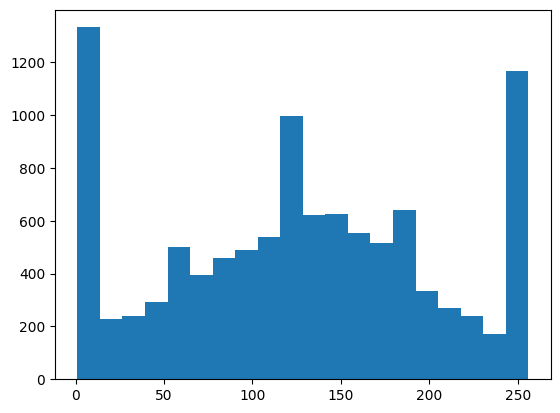

In [35]:
plt.hist(labels_list, bins= 20)

From the paper, they use -12.7 and 12.8 as the range to assign 1 to 256 to each label. I'm curious is the range fixed or can be adjusted based on the actual range of delta_G.

To avoid obscure issue when recover the label, we use 10 and 90 percentile as the range instead of -12.7 and 12.8.


# Build the dilate CNN

## Pytorch

Still in old pytorch version

In [ ]:
# Convert lists to PyTorch tensors
features_tensor = torch.tensor(features_list, dtype=torch.float32)
labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D

feature_label_tensor = TensorDataset(features_tensor, labels_tensor)


train_loader = DataLoader(feature_label_tensor, batch_size=32, shuffle=True)

# Example of using DataLoader in a training loop
for features, labels in train_loader:
    print("Features batch shape:", features.shape)
    print("Label batch shape:", labels.shape)
    # Example: print(features, labels)
    break

In [1]:
import torch
from wavenet_model import *
# from audio_data import WavenetDataset
from wavenet_training import *
from model_logging import *

ModuleNotFoundError: No module named 'wavenet_modules'

In [ ]:
# initialize cuda option
dtype = torch.FloatTensor # data type
ltype = torch.LongTensor # label type

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('use gpu')
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

## Tensorflow 1.X. 

This version is too old and hard to understand and implement. So currently deprecated this part in this study

In [52]:
import tensorflow as tf

# Assuming 'features_list' and 'labels_list' are already defined and are numpy arrays
features_tensor = tf.convert_to_tensor(features_list, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels_list, dtype=tf.float32)
labels_tensor = tf.expand_dims(labels_tensor, axis=1)  # Making labels tensor 2D

# Create a Dataset object
dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor))


In [53]:
# Set batch size and shuffle buffer size
batch_size = 32
shuffle_buffer_size = 1000  # Adjust this number based on the size of your dataset

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
dataset = dataset.batch(batch_size)


In [54]:
# Create a TensorFlow iterator
iterator = iter(dataset)

# Example of using the iterator in a training loop
features, labels = next(iterator)
print("Features batch shape:", features.shape)
print("Label batch shape:", labels.shape)


Features batch shape: (32, 64)
Label batch shape: (32, 1)


In [55]:
# Directly use the dataset in a loop
for features, labels in dataset.take(1):  # The 'take(1)' method fetches one batch
    print("Features batch shape:", features.shape)
    print("Label batch shape:", labels.shape)
    # Example: print(features.numpy(), labels.numpy())
    break


Features batch shape: (32, 64)
Label batch shape: (32, 1)


In [ ]:
# Define a model, loss, and optimizer (assuming a simple model for demonstration)
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(10, activation='relu', input_shape=(features.shape[-1],)),
#     tf.keras.layers.Dense(1)
# ])

# loss_object = tf.keras.losses.MeanSquaredError()
# optimizer = tf.keras.optimizers.Adam()

# # Training step
# for features, labels in dataset:
#     with tf.GradientTape() as tape:
#         predictions = model(features, training=True)
#         loss = loss_object(labels, predictions)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     print("Current loss:", loss.numpy())


In [56]:
from __future__ import print_function

import argparse
from datetime import datetime
import json
import os
import sys
import time

import tensorflow as tf
from tensorflow.python.client import timeline

from wavenet import WaveNetModel, optimizer_factory

In [62]:
BATCH_SIZE = 1
# DATA_DIRECTORY = './VCTK-Corpus'
LOGDIR_ROOT = './logdir'
CHECKPOINT_EVERY = 50
NUM_STEPS = int(1e5)
LEARNING_RATE = 1e-3
WAVENET_PARAMS = './wavenet_params.json'
STARTED_DATESTRING = "{0:%Y-%m-%dT%H-%M-%S}".format(datetime.now())
SAMPLE_SIZE = 100000
L2_REGULARIZATION_STRENGTH = 0
SILENCE_THRESHOLD = 0.3
EPSILON = 0.001
MOMENTUM = 0.9
MAX_TO_KEEP = 5
METADATA = False

In [66]:
def get_arguments():
    class Args:
        batch_size = 1
        store_metadata = False
        logdir = None  # Directly specify if needed or use logdir_root
        logdir_root = './logdir'
        restore_from = None
        checkpoint_every = 50
        num_steps = int(1e5)
        learning_rate = 1e-3
        wavenet_params = './wavenet_params.json'
        started_datestring = "{0:%Y-%m-%dT%H-%M-%S}".format(datetime.now())
        sample_size = 100000
        l2_regularization_strength = 0
        silence_threshold = 0.3
        optimizer = 'adam'
        momentum = 0.9
        histograms = False
        gc_channels = None
        max_checkpoints = 5

    return Args()

In [63]:
# def get_arguments():
#     def _str_to_bool(s):
#         """Convert string to bool (in argparse context)."""
#         if s.lower() not in ['true', 'false']:
#             raise ValueError('Argument needs to be a '
#                              'boolean, got {}'.format(s))
#         return {'true': True, 'false': False}[s.lower()]

#     parser = argparse.ArgumentParser(description='WaveNet example network')
#     parser.add_argument('--batch_size', type=int, default=BATCH_SIZE,
#                         help='How many wav files to process at once. Default: ' + str(BATCH_SIZE) + '.')
#     # parser.add_argument('--data_dir', type=str, default=DATA_DIRECTORY,
#     #                     help='The directory containing the VCTK corpus.')
#     parser.add_argument('--store_metadata', type=bool, default=METADATA,
#                         help='Whether to store advanced debugging information '
#                         '(execution time, memory consumption) for use with '
#                         'TensorBoard. Default: ' + str(METADATA) + '.')
#     parser.add_argument('--logdir', type=str, default=None,
#                         help='Directory in which to store the logging '
#                         'information for TensorBoard. '
#                         'If the model already exists, it will restore '
#                         'the state and will continue training. '
#                         'Cannot use with --logdir_root and --restore_from.')
#     parser.add_argument('--logdir_root', type=str, default=None,
#                         help='Root directory to place the logging '
#                         'output and generated model. These are stored '
#                         'under the dated subdirectory of --logdir_root. '
#                         'Cannot use with --logdir.')
#     parser.add_argument('--restore_from', type=str, default=None,
#                         help='Directory in which to restore the model from. '
#                         'This creates the new model under the dated directory '
#                         'in --logdir_root. '
#                         'Cannot use with --logdir.')
#     parser.add_argument('--checkpoint_every', type=int,
#                         default=CHECKPOINT_EVERY,
#                         help='How many steps to save each checkpoint after. Default: ' + str(CHECKPOINT_EVERY) + '.')
#     parser.add_argument('--num_steps', type=int, default=NUM_STEPS,
#                         help='Number of training steps. Default: ' + str(NUM_STEPS) + '.')
#     parser.add_argument('--learning_rate', type=float, default=LEARNING_RATE,
#                         help='Learning rate for training. Default: ' + str(LEARNING_RATE) + '.')
#     parser.add_argument('--wavenet_params', type=str, default=WAVENET_PARAMS,
#                         help='JSON file with the network parameters. Default: ' + WAVENET_PARAMS + '.')
#     parser.add_argument('--sample_size', type=int, default=SAMPLE_SIZE,
#                         help='Concatenate and cut audio samples to this many '
#                         'samples. Default: ' + str(SAMPLE_SIZE) + '.')
#     parser.add_argument('--l2_regularization_strength', type=float,
#                         default=L2_REGULARIZATION_STRENGTH,
#                         help='Coefficient in the L2 regularization. '
#                         'Default: False')
#     parser.add_argument('--silence_threshold', type=float,
#                         default=SILENCE_THRESHOLD,
#                         help='Volume threshold below which to trim the start '
#                         'and the end from the training set samples. Default: ' + str(SILENCE_THRESHOLD) + '.')
#     parser.add_argument('--optimizer', type=str, default='adam',
#                         choices=optimizer_factory.keys(),
#                         help='Select the optimizer specified by this option. Default: adam.')
#     parser.add_argument('--momentum', type=float,
#                         default=MOMENTUM, help='Specify the momentum to be '
#                         'used by sgd or rmsprop optimizer. Ignored by the '
#                         'adam optimizer. Default: ' + str(MOMENTUM) + '.')
#     parser.add_argument('--histograms', type=_str_to_bool, default=False,
#                         help='Whether to store histogram summaries. Default: False')
#     parser.add_argument('--gc_channels', type=int, default=None,
#                         help='Number of global condition channels. Default: None. Expecting: Int')
#     parser.add_argument('--max_checkpoints', type=int, default=MAX_TO_KEEP,
#                         help='Maximum amount of checkpoints that will be kept alive. Default: '
#                              + str(MAX_TO_KEEP) + '.')
#     return parser.parse_args()

In [64]:
def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')


def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir),
          end="")

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...", end="")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None


def get_default_logdir(logdir_root):
    logdir = os.path.join(logdir_root, 'train', STARTED_DATESTRING)
    return logdir


def validate_directories(args):
    """Validate and arrange directory related arguments."""

    # Validation
    if args.logdir and args.logdir_root:
        raise ValueError("--logdir and --logdir_root cannot be "
                         "specified at the same time.")

    if args.logdir and args.restore_from:
        raise ValueError(
            "--logdir and --restore_from cannot be specified at the same "
            "time. This is to keep your previous model from unexpected "
            "overwrites.\n"
            "Use --logdir_root to specify the root of the directory which "
            "will be automatically created with current date and time, or use "
            "only --logdir to just continue the training from the last "
            "checkpoint.")

    # Arrangement
    logdir_root = args.logdir_root
    if logdir_root is None:
        logdir_root = LOGDIR_ROOT

    logdir = args.logdir
    if logdir is None:
        logdir = get_default_logdir(logdir_root)
        print('Using default logdir: {}'.format(logdir))

    restore_from = args.restore_from
    if restore_from is None:
        # args.logdir and args.restore_from are exclusive,
        # so it is guaranteed the logdir here is newly created.
        restore_from = logdir

    return {
        'logdir': logdir,
        'logdir_root': args.logdir_root,
        'restore_from': restore_from
    }


In [68]:
args = get_arguments()

try:
    directories = validate_directories(args)
except ValueError as e:
    print("Some arguments are wrong:")
    print(str(e))
    

logdir = directories['logdir']
restore_from = directories['restore_from']

# Even if we restored the model, we will treat it as new training
# if the trained model is written into an arbitrary location.
is_overwritten_training = logdir != restore_from

with open(args.wavenet_params, 'r') as f:
    wavenet_params = json.load(f)

# Create coordinator.
coord = tf.train.Coordinator()



Using default logdir: ./logdir\train\2024-05-19T22-31-09


In [69]:
# Create network.
net = WaveNetModel(
    batch_size=args.batch_size,
    dilations=wavenet_params["dilations"],
    filter_width=wavenet_params["filter_width"],
    residual_channels=wavenet_params["residual_channels"],
    dilation_channels=wavenet_params["dilation_channels"],
    skip_channels=wavenet_params["skip_channels"],
    quantization_channels=wavenet_params["quantization_channels"],
    use_biases=wavenet_params["use_biases"],
    scalar_input=wavenet_params["scalar_input"],
    initial_filter_width=wavenet_params["initial_filter_width"],
    histograms=args.histograms,
    global_condition_channels=args.gc_channels,
    global_condition_cardinality=None)

if args.l2_regularization_strength == 0:
    args.l2_regularization_strength = None
loss = net.loss(input_batch=dataset,
                global_condition_batch=None,
                l2_regularization_strength=args.l2_regularization_strength)
optimizer = optimizer_factory[args.optimizer](
                learning_rate=args.learning_rate,
                momentum=args.momentum)
trainable = tf.trainable_variables()
optim = optimizer.minimize(loss, var_list=trainable)

AttributeError: module 'tensorflow' has no attribute 'variable_scope'

In [ ]:
import tensorflow as tf

def create_variable(name, shape):
    """Create a trainable variable."""
    return tf.Variable(initial_value=tf.random.normal(shape), name=name, trainable=True)

def create_bias_variable(name, shape):
    """Create a bias variable initialized to zero."""
    return tf.Variable(initial_value=tf.zeros(shape), name=name, trainable=True)

class WaveNetModel(tf.keras.Model):
    def __init__(self, dilations, filter_width, residual_channels, dilation_channels, skip_channels, 
                 quantization_channels, use_biases=False, global_condition_channels=None, 
                 global_condition_cardinality=None, scalar_input=False, initial_filter_width=32, **kwargs):
        super(WaveNetModel, self).__init__(**kwargs)
        self.scalar_input = scalar_input
        self.initial_filter_width = initial_filter_width
        self.dilations = dilations
        self.filter_width = filter_width
        self.residual_channels = residual_channels
        self.dilation_channels = dilation_channels
        self.skip_channels = skip_channels
        self.quantization_channels = quantization_channels
        self.use_biases = use_biases
        self.global_condition_channels = global_condition_channels
        self.global_condition_cardinality = global_condition_cardinality

        # Build model layers
        self.build_layers()

    def build_layers(self):
        if self.global_condition_cardinality is not None:
            self.gc_embedding = tf.keras.layers.Embedding(self.global_condition_cardinality,
                                                          self.global_condition_channels,
                                                          name='gc_embedding')

        self.causal_layer = tf.keras.layers.Conv1D(filters=self.residual_channels,
                                                   kernel_size=self.initial_filter_width if self.scalar_input else self.filter_width,
                                                   padding='causal',
                                                   use_bias=self.use_biases,
                                                   name='causal_layer')

        self.dilated_layers = []
        for i, dilation in enumerate(self.dilations):
            self.dilated_layers.append(
                tf.keras.layers.Conv1D(filters=self.dilation_channels,
                                       kernel_size=self.filter_width,
                                       dilation_rate=dilation,
                                       padding='causal',
                                       activation='tanh',
                                       use_bias=self.use_biases,
                                       name=f'dilated_conv_{i}')
            )

        self.post_process1 = tf.keras.layers.Conv1D(filters=self.skip_channels,
                                                    kernel_size=1,
                                                    activation='relu',
                                                    use_bias=self.use_biases,
                                                    name='postprocess1')
        self.post_process2 = tf.keras.layers.Conv1D(filters=self.quantization_channels,
                                                    kernel_size=1,
                                                    activation='relu',
                                                    use_bias=self.use_biases,
                                                    name='postprocess2')

    def call(self, inputs, training=None, mask=None):
        x = self.causal_layer(inputs)
        for layer in self.dilated_layers:
            x = layer(x)

        x = self.post_process1(x)
        x = self.post_process2(x)
        return x

# Example instantiation and use
model = WaveNetModel(dilations=[1, 2, 4], filter_width=2, residual_channels=32, dilation_channels=64,
                     skip_channels=128, quantization_channels=256, use_biases=True)
